# CST383 Final Project

### Team Members:
*   Emma George
*   Shawn Khalighi
*   Roy Luengas
*   Kevin Wical

## Objective
We will build a system to predict a Job Category based on a resume's contents.
We will use the features 'Job Titles' and 'Top Word {1-5}' to predict the Job Category from a resume.

Present categories are HR, Designer, Information-Technology, Teacher, Advocate, Business-Development, Healthcare, Fitness, Agriculture, BPO, Sales, Consultant, Digital-Media, Automobile, Chef, Finance, Apparel, Engineering, Accountant, Construction, Public-Relations, Banking, Arts, Aviation.

## Read the Data

In [37]:
!pip install wordcloud

In [38]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from matplotlib import rcParams
from wordcloud import WordCloud, STOPWORDS
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

sns.set()
rcParams['figure.figsize'] = 8,6
sns.set_context('talk')   # 'talk' for slightly larger

In [39]:
# Load dataset
df = pd.read_csv('Resume.csv')
print(df)

            ID                                         Resume_str  \
0     16852973           HR ADMINISTRATOR/MARKETING ASSOCIATE\...   
1     22323967           HR SPECIALIST, US HR OPERATIONS      ...   
2     33176873           HR DIRECTOR       Summary      Over 2...   
3     27018550           HR SPECIALIST       Summary    Dedica...   
4     17812897           HR MANAGER         Skill Highlights  ...   
...        ...                                                ...   
2479  99416532           RANK: SGT/E-5 NON- COMMISSIONED OFFIC...   
2480  24589765           GOVERNMENT RELATIONS, COMMUNICATIONS ...   
2481  31605080           GEEK SQUAD AGENT         Professional...   
2482  21190805           PROGRAM DIRECTOR / OFFICE MANAGER    ...   
2483  37473139           STOREKEEPER II       Professional Sum...   

                                            Resume_html  Category  
0     <div class="fontsize fontface vmargins hmargin...        HR  
1     <div class="fontsize fontface

## Initial Exploration

In [40]:
# How much data is there?
df.shape

(2484, 4)

In [41]:
# How many NA values are in the data?
df.isnull().sum()

ID             0
Resume_str     0
Resume_html    0
Category       0
dtype: int64

**Does the dataset contain much obviously bad data?**

The dataset does not contain much obviously bad data. All cells appear to be filled with the appropriate information.

In [42]:
# What are the types of the columns?
df.dtypes
# ID is a unique int64 value.
# Resume_str is an object containing the string representation of a resume's contents
# Resume_html is an object containing a string of HTML representing a resume file.
# Category is an object containing a string referring to the Job Category of the Resume.

ID              int64
Resume_str     object
Resume_html    object
Category       object
dtype: object

In [43]:
# How much data per Job Category?
df['Category'].value_counts()

INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      120
FINANCE                   118
ADVOCATE                  118
ACCOUNTANT                118
ENGINEERING               118
CHEF                      118
AVIATION                  117
FITNESS                   117
SALES                     116
BANKING                   115
HEALTHCARE                115
CONSULTANT                115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TEACHER                   102
APPAREL                    97
DIGITAL-MEDIA              96
AGRICULTURE                63
AUTOMOBILE                 36
BPO                        22
Name: Category, dtype: int64

## Initial Preprocessing and Cleaning

In [44]:
# Find duplicate resumes, and remove repeated.
initial_size = df.shape[0]
print('Number of unique resume strings: ',df['Resume_str'].unique().size)
print('Number of unique resume html strings: ',df['Resume_html'].unique().size)
print('Number of unique resume IDs: ',df['ID'].unique().size)
df = df.drop_duplicates(subset=['Resume_str','Resume_html'])
print('Dropped',initial_size-df.shape[0],'duplicate resumes.')

Number of unique resume strings:  2482
Number of unique resume html strings:  2482
Number of unique resume IDs:  2484
Dropped 2 duplicate resumes.


In [45]:
# Cleaning the Resume_str column to remove non alphanumeric characters
df['cleaned_resume_str'] = df['Resume_str'].str.replace(r'[^a-zA-Z\s]', ' ').str.lower()

# Creating a dictionary of the most common words for each category
def get_dictionary_entry(category):
    category_data = df[df['Category'] == category]
    text = ' '.join(category_data['cleaned_resume_str']).lower()
    stopwords = set(STOPWORDS)
    stopwords.update(['city','state','company','name','hr'])
    wc = WordCloud(max_words=5,stopwords=stopwords).generate(text)
    
    words = list(wc.words_.keys())
    #word_frequency = wc.words_
    return words

categories = df['Category'].unique()
# This dictionary ended up unused
top5_dictionary = {}
for category in categories:
    top5_dictionary[category] = get_dictionary_entry(category)
    
# Add columns for the top 1-5  most common words, and fill them with their frequency
for category, words in top5_dictionary.items():
    for i, word in enumerate(words):
        df.loc[df['Category'] == category, f'Top Word {i+1}'] = df.loc[df['Category'] == category, 'cleaned_resume_str'].str.count(word)


C:\Users\emmar\AppData\Local\Temp\ipykernel_16436\2932164092.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['cleaned_resume_str'] = df['Resume_str'].str.replace(r'[^a-zA-Z\s]', ' ').str.lower()


In [46]:
# How much data per Job Category after removing repeated resumes?
df['Category'].value_counts()

INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      120
ADVOCATE                  118
ACCOUNTANT                118
ENGINEERING               118
CHEF                      118
FINANCE                   117
FITNESS                   117
AVIATION                  116
SALES                     116
BANKING                   115
HEALTHCARE                115
CONSULTANT                115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TEACHER                   102
APPAREL                    97
DIGITAL-MEDIA              96
AGRICULTURE                63
AUTOMOBILE                 36
BPO                        22
Name: Category, dtype: int64

## Exploration and Visualization

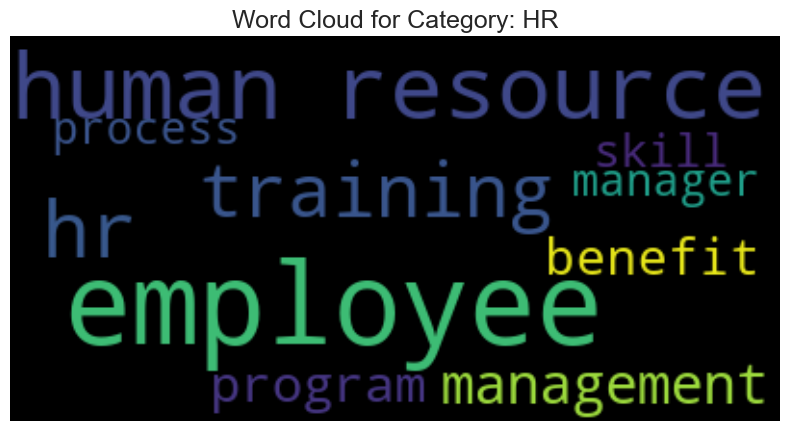

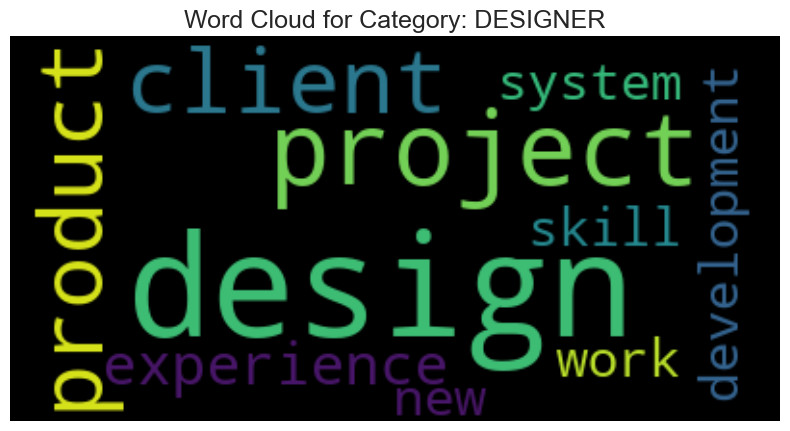

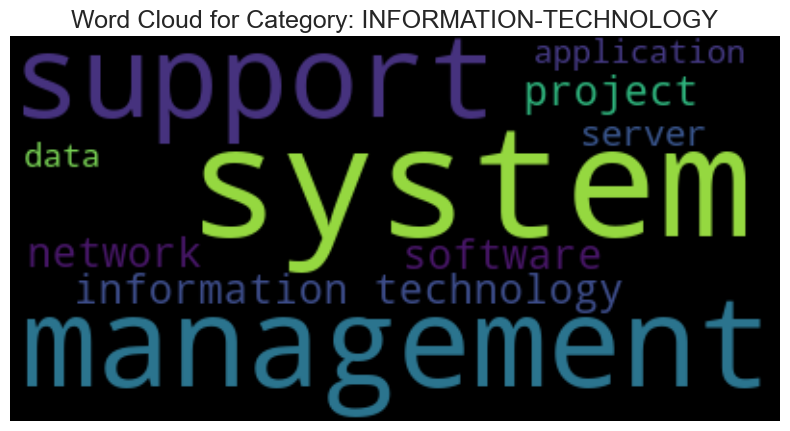

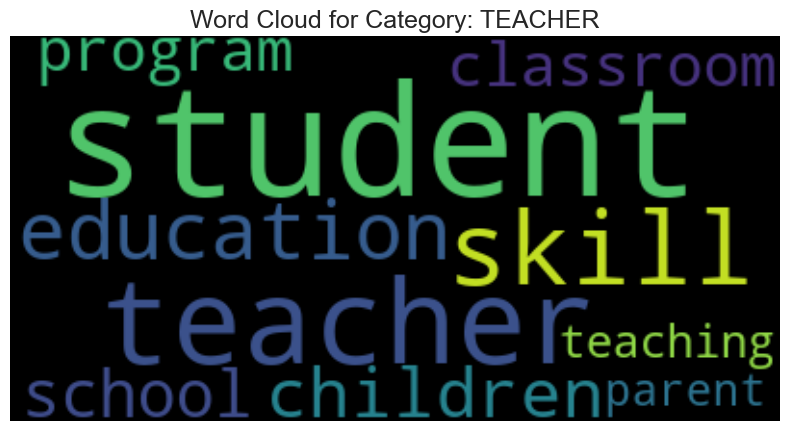

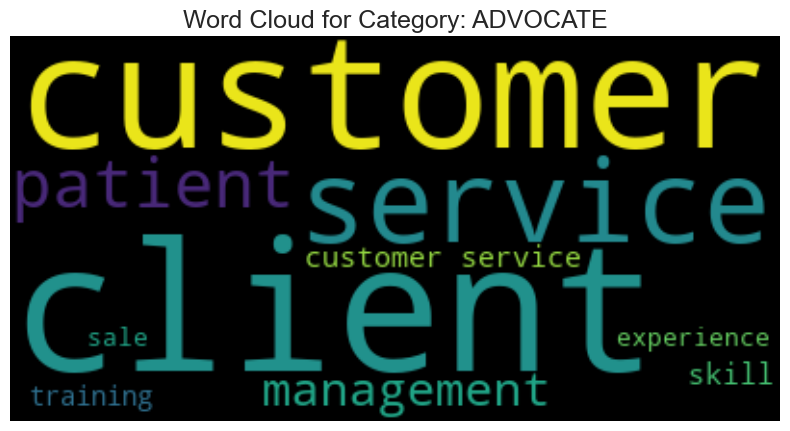

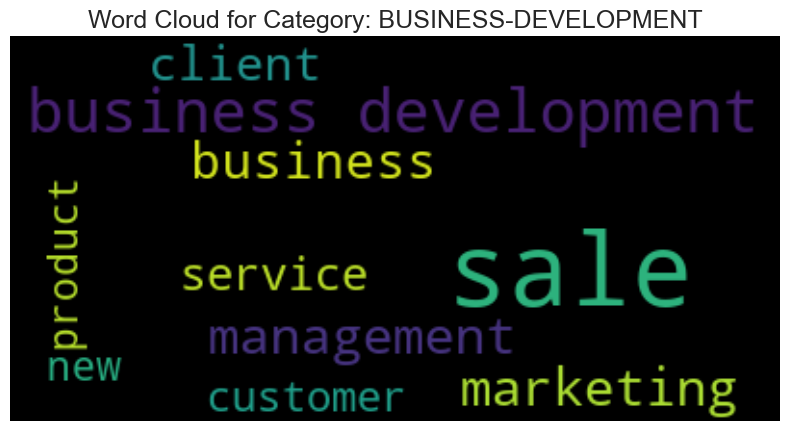

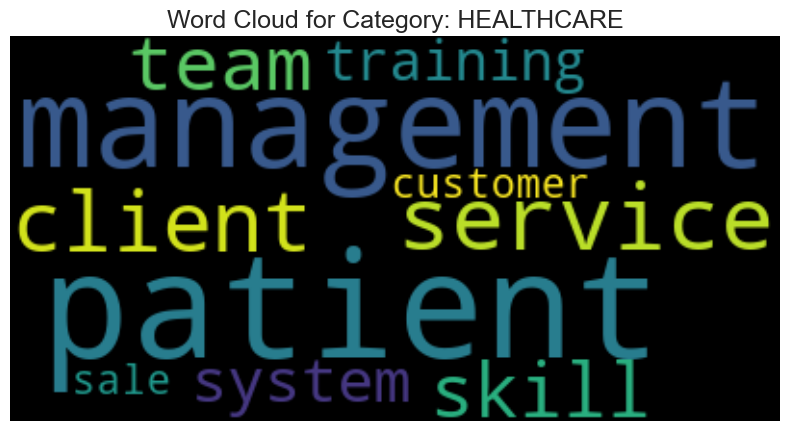

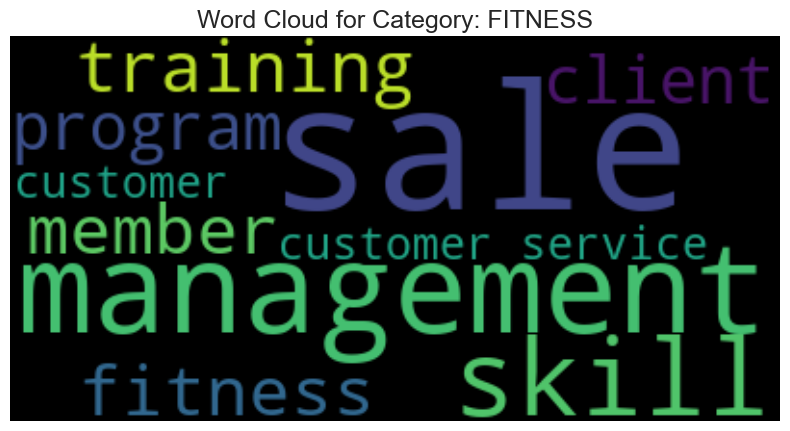

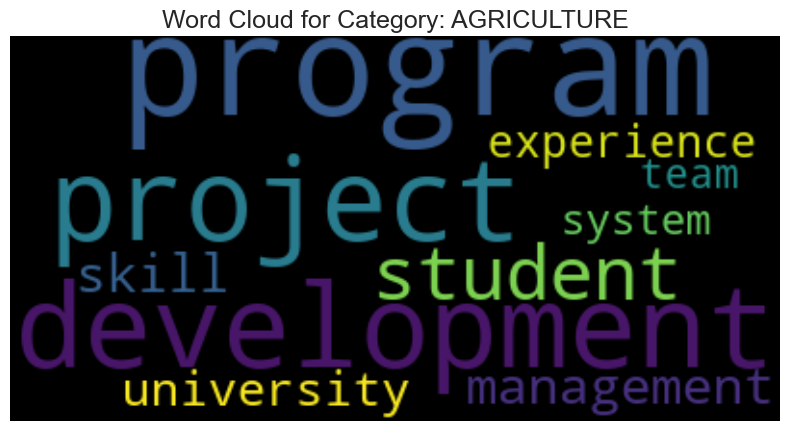

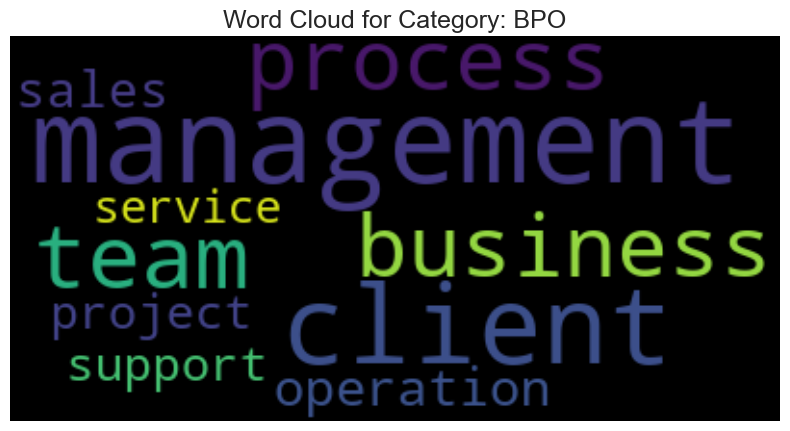

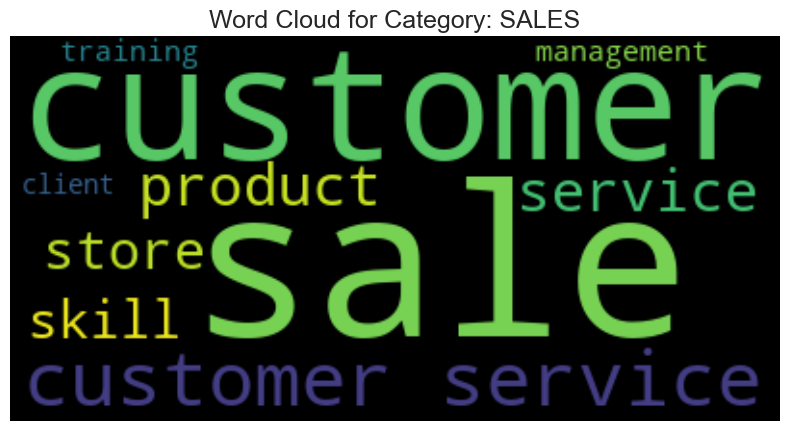

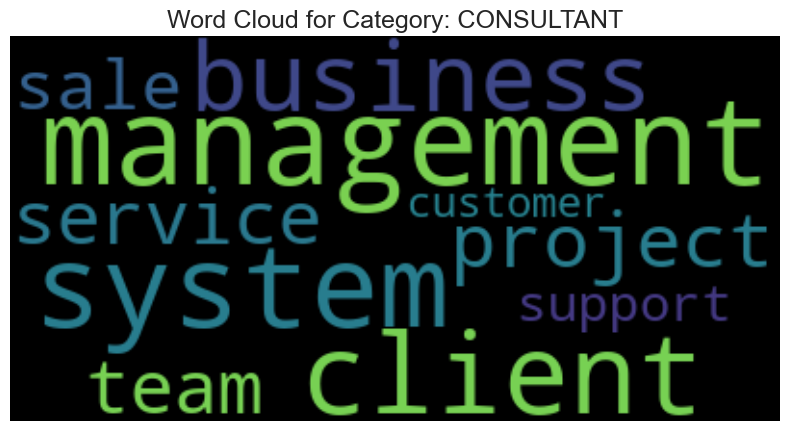

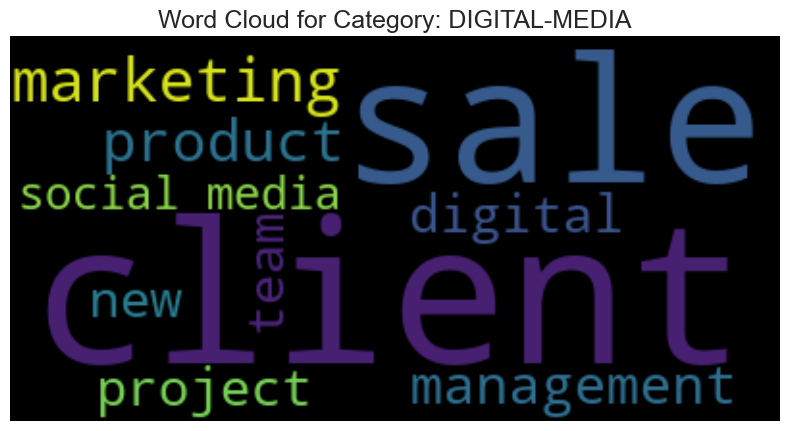

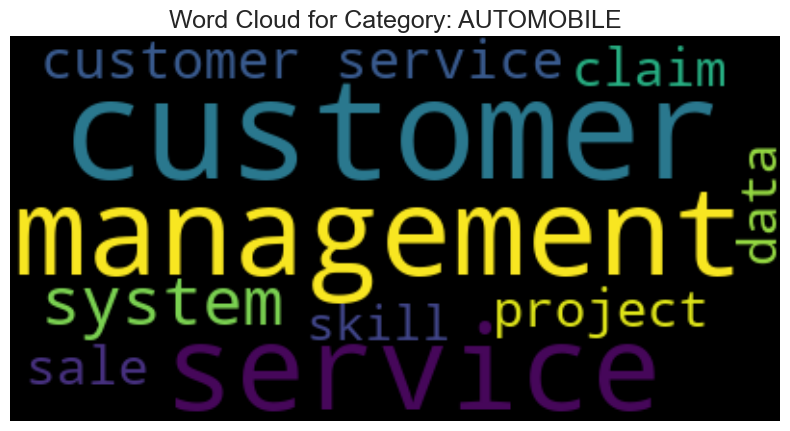

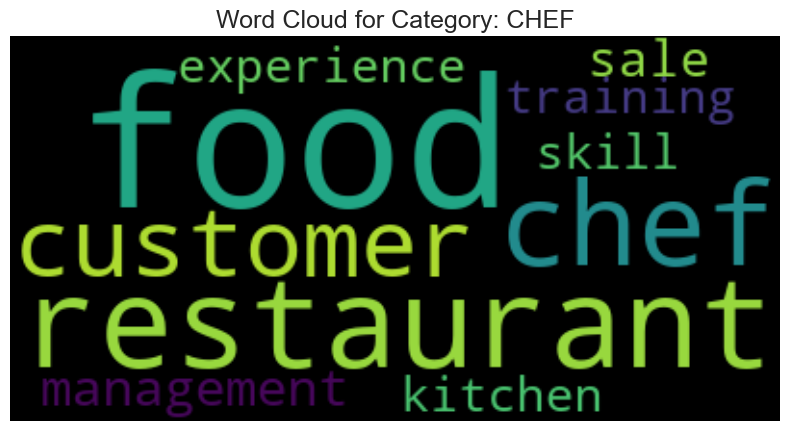

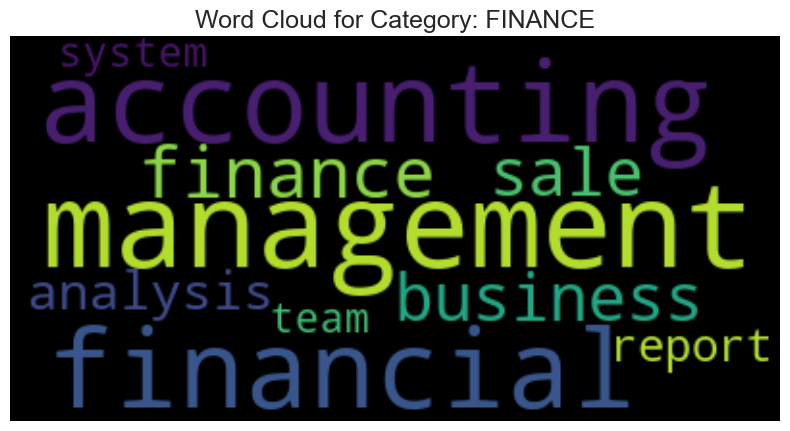

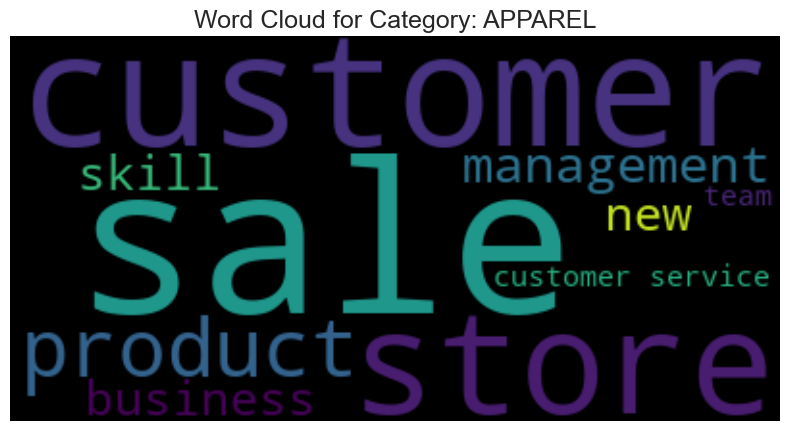

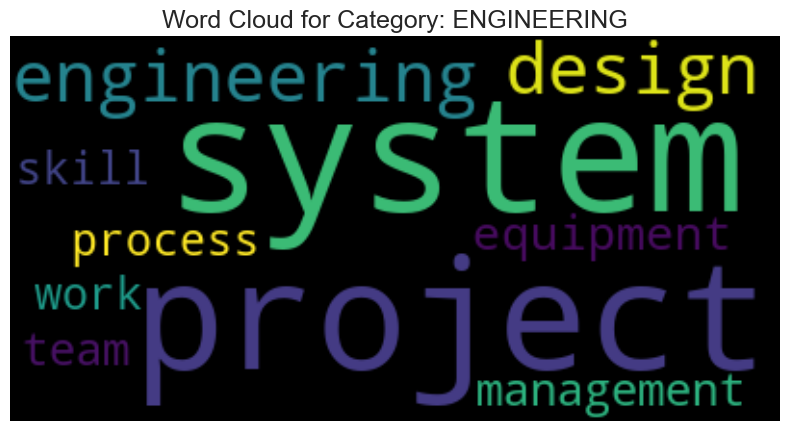

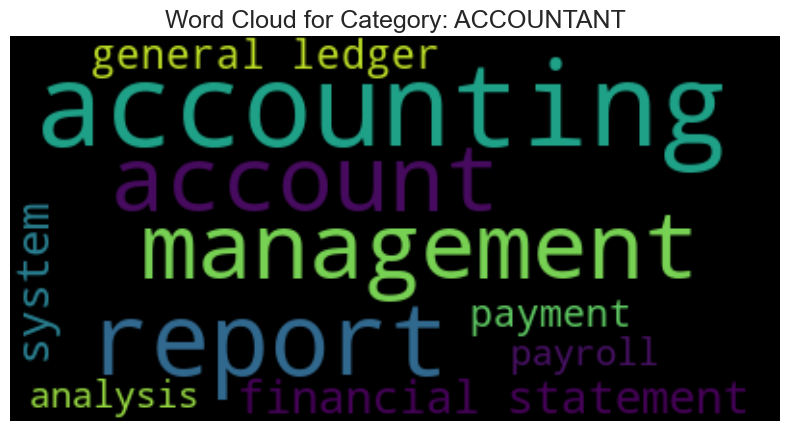

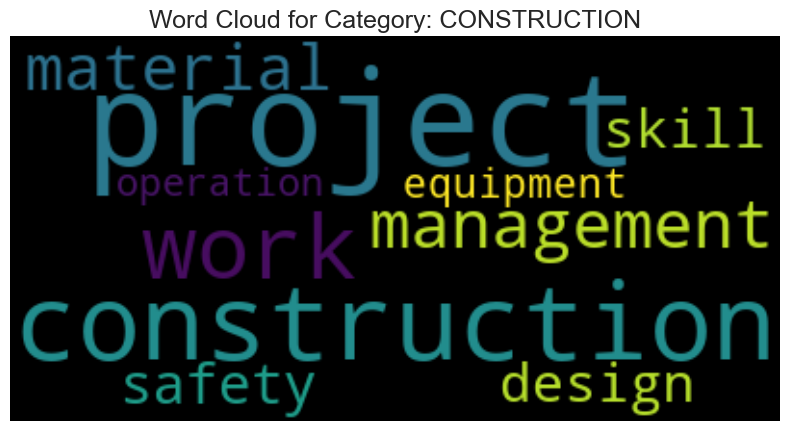

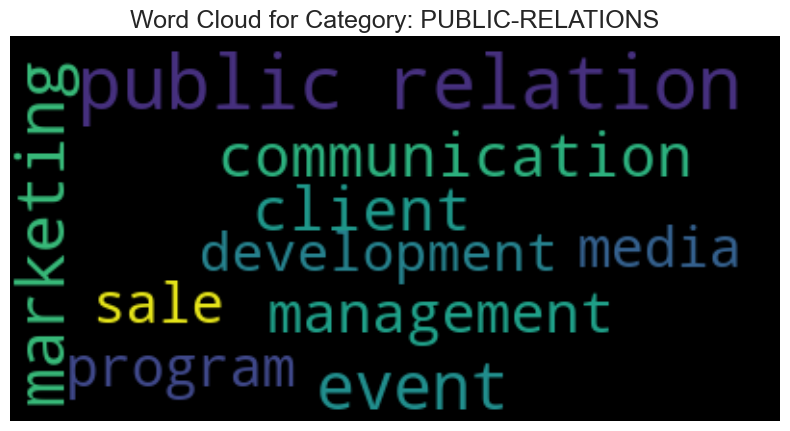

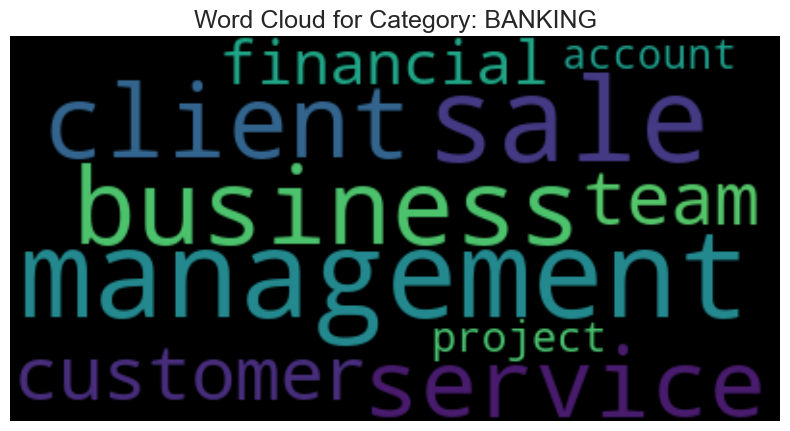

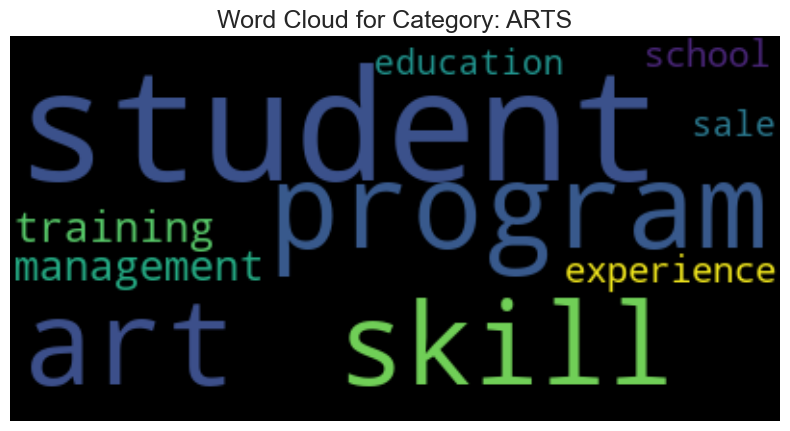

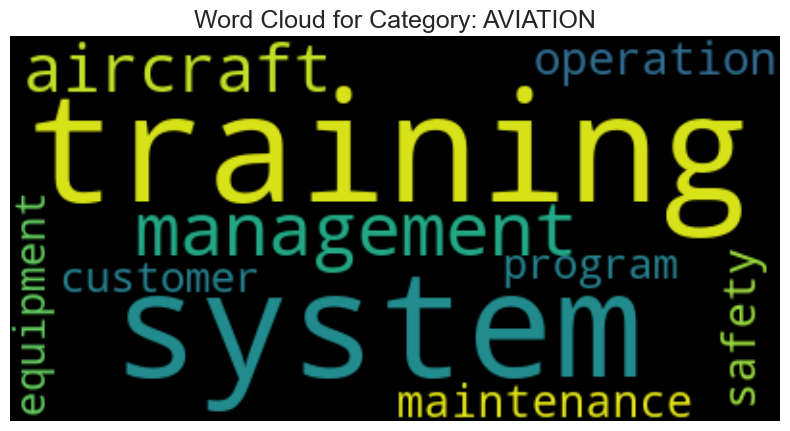

In [47]:
# Get a list of the unique categories, and then create a WordCloud with the 10 most common words in each category
def make_cloud(category):
    cat_data = df[df['Category'] == category]
    text = ' '.join(cat_data['Resume_str']).lower()
    stopwords = set(STOPWORDS)
    stopwords.update(['city','state','company','name'])
    wc = WordCloud(max_words=10,stopwords=stopwords).generate(text)
    
    # Dictionary containing top 10 words with relative frequency (unused)
    #freq_dict = wc.words_
    #print(freq_dict)
    
    plt.figure(figsize=(10,5) )
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud for Category: {}'.format(category))
    plt.show()
    
categories = df['Category'].unique()

for category in categories:
    make_cloud(category)

In [48]:
# Extract job title data (Main job title + Past job titles)
df['Job Titles'] = df['Resume_html'].apply(lambda x: BeautifulSoup(x, 'html.parser').find_all('span', class_='jobtitle'))
df['Job Titles'] = df['Job Titles'].apply(lambda x: [span.text for span in x])
df['Job Titles'] = df['Job Titles'].apply(lambda x: x[0] if len(x) > 0 else '')
print(df['Job Titles'])

# Remove unwanted characters for use with the model.
df['cleaned_job'] = df['Job Titles'].str.replace(r'[^a-zA-Z\s]', ' ').str.lower().str.strip()

0        HR Administrator/Marketing Associate\n\nHR Ad...
1                         HR Specialist, US HR Operations
2                                             HR Director
3                                           Hr Specialist
4                                              HR Manager
                              ...                        
2478              Advanced Level Wheeled Vehicle Mechanic
2479     Rank: SGT/E-5 Non- Commissioned Officer in Ch...
2480     Government Relations, Communications and Orga...
2481                                     Geek Squad Agent
2482                    Program Director / Office Manager
Name: Job Titles, Length: 2482, dtype: object


C:\Users\emmar\AppData\Local\Temp\ipykernel_16436\2852155734.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df['cleaned_job'] = df['Job Titles'].str.replace(r'[^a-zA-Z\s]', ' ').str.lower().str.strip()


In [49]:
# Number of unique job titles per category
unique_titles_per_category = df.explode('Job Titles').groupby('Category')['Job Titles'].nunique()
print(unique_titles_per_category)

Category
ACCOUNTANT                 29
ADVOCATE                  100
AGRICULTURE                61
APPAREL                    94
ARTS                       99
AUTOMOBILE                 35
AVIATION                  109
BANKING                   109
BPO                        22
BUSINESS-DEVELOPMENT       53
CHEF                       75
CONSTRUCTION               96
CONSULTANT                 29
DESIGNER                   78
DIGITAL-MEDIA              91
ENGINEERING                73
FINANCE                    70
FITNESS                   101
HEALTHCARE                107
HR                         70
INFORMATION-TECHNOLOGY     88
PUBLIC-RELATIONS           95
SALES                      39
TEACHER                    34
Name: Job Titles, dtype: int64


## Determine any bias our labels might have
As shown in the plot below and when looking at the job titles, we noticed some interesting patterns that could indicate bias. The 'AVIATION' category had the most unique job titles, showing a wide range of options. 'APPAREL' and 'HEALTHCARE' categories also had a good variety of job titles. On the other hand, the 'BPO' category had the fewest unique job titles. To understand bias better, it's important to look at the specific job titles in each category and see if there are any differences in representation for different groups. This analysis gives us a starting point to dig deeper into potential biases in job labels

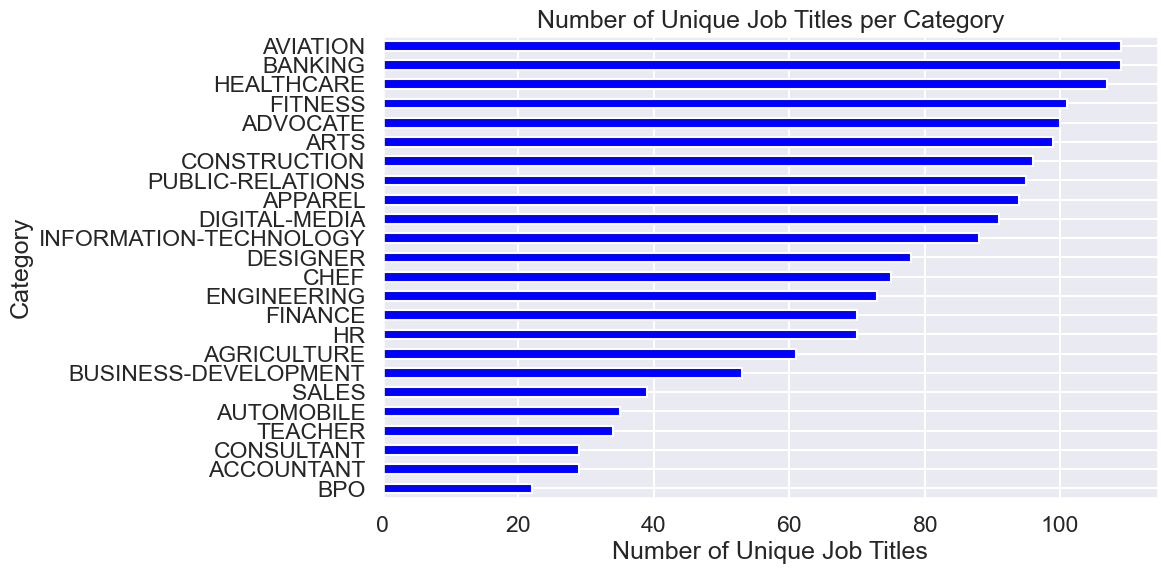

In [50]:
sorted_data = unique_titles_per_category.sort_values(ascending=True)
plt.figure(figsize=(10, 6))
sorted_data.plot(kind='barh', color='blue')
plt.title('Number of Unique Job Titles per Category')
plt.xlabel('Number of Unique Job Titles')
plt.ylabel('Category')

plt.show()

Visualization options: 

*   histograms of single numeric variables
*   bar plots of value counts of single categorical variables
*   grid of scatter plots (numeric variables)
*   violin/bar plots for categorical/numeric variable pairs
*   three-variable plots, such as scatterplots with color or shape of points as a third variable, or grouped bar plots

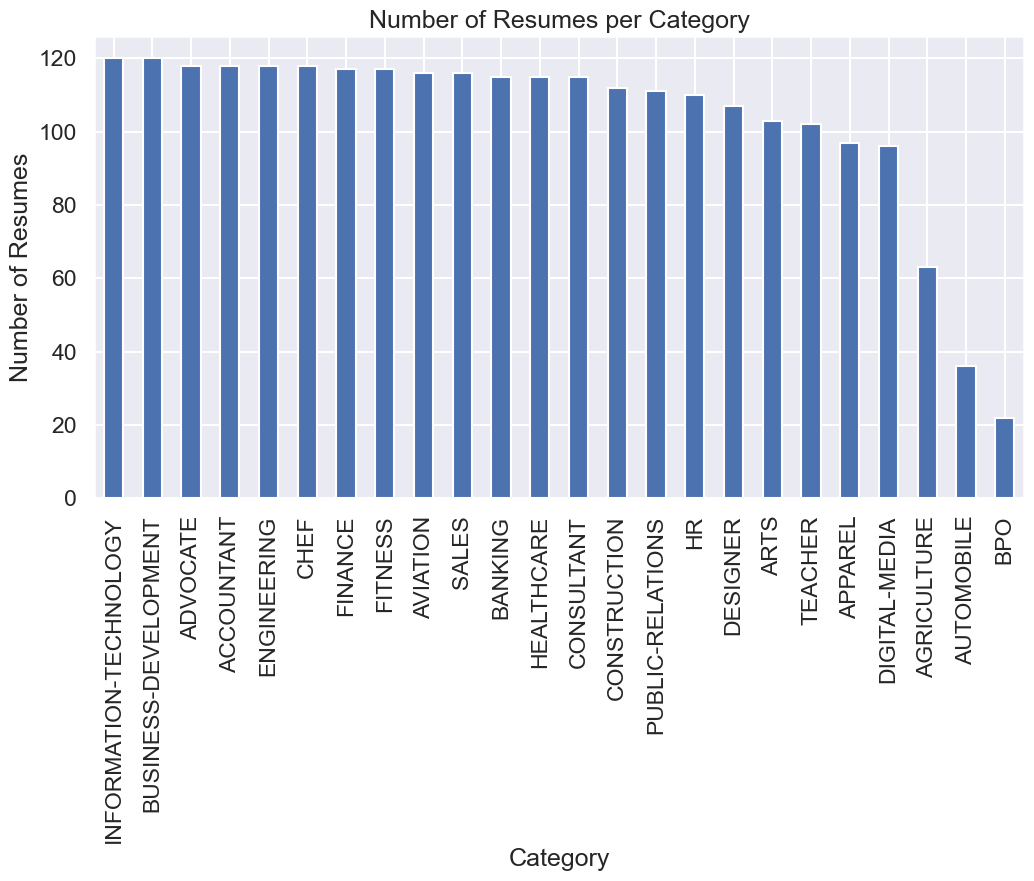

In [51]:
# Bar plot displaying the number of Resumes per Job Category. 
category_counts = df['Category'].value_counts()
category_counts.plot(kind='bar', figsize=(12, 6))
plt.title('Number of Resumes per Category')
plt.xlabel('Category')
plt.ylabel('Number of Resumes')
plt.show()

## Machine Learning

In [52]:
# Preliminary test/train dataset split

# classification problem: predict which job category a resume belongs to

df['cleaned_job'] = df['Job Titles'].str.replace(r'[^a-zA-Z\s]', ' ').str.lower().str.strip()

# select predictor variables and target variable
predictors = 'cleaned_resume_str'
target = 'Category'
X = df[predictors]
y = df[target]

stopwords = list(STOPWORDS)
stopwords += ['city','state','company','name','yr','yrs','year','years',
              'month','montly','role','relevant','coursework','months','related','quarter','quarterly','via','responsibilities','objectives','gpa','employee','employees','united','states','week','weekly','annual','experience','highlights','ability','accomplishments','objective','skills','current','to','aug','sep','oct','nov','dec','jan','feb','mar','apr','may','jun','jul','august','september','october','november','december','january','march','april','june','july','work','worked','working','works','problem','united states','us','usa','th','aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn','summary']


# Create a vocabulary dictionary from cleaned job titles.
num_features = 0
vocab = dict()
for title in df['cleaned_job']:
    if title not in vocab:
        vocab[title] = num_features
        num_features += 1

# test/train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=8)
vectorizer = TfidfVectorizer(stop_words=stopwords, ngram_range=(1,3), vocabulary=vocab, max_features=num_features)
X_train_vector = vectorizer.fit_transform(X_train)
X_test_vector = vectorizer.fit_transform(X_test)

# build a Multinomial Naive Bayes Classifier
mnb = MultinomialNB()

mnb.fit(X_train_vector, y_train)
predicted = mnb.predict(X_test_vector)

C:\Users\emmar\AppData\Local\Temp\ipykernel_16436\793434032.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['cleaned_job'] = df['Job Titles'].str.replace(r'[^a-zA-Z\s]', ' ').str.lower().str.strip()


In [53]:
print("Accuracy Score:", metrics.accuracy_score(y_test,predicted))

Accuracy Score: 0.6201342281879194


<Axes: >

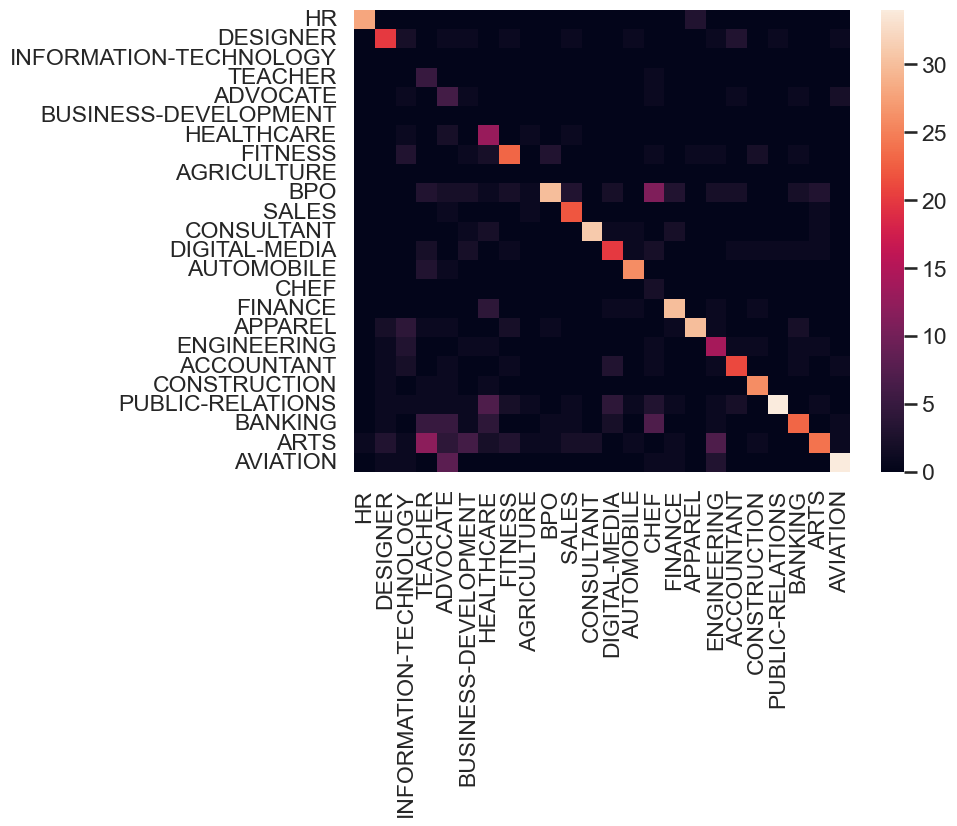

In [54]:
# Confusion matrix
mat = metrics.confusion_matrix(y_test,predicted)
sns.heatmap(mat.T, xticklabels=categories,yticklabels=categories)